In [1]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from scipy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time

# Stochastic processes

##### Data from Meyer & Bijeljic 2016

In [2]:
#Bentheimer 300 parameters
Bentheimer300 ={
'name'  : 'Bentheimer 300',
'omegat':  5.0,
'taut'  :  0.093,
'sigmat':  0.59,
'mut'   :  41.0,
'taub'  :  0.11,
'bb'    :  2.0,
'b'     :  0.56,
'c'     :  1.1,
'alpha' : -4.7,
'mu'    :  1.5,
'sigma' :  2.7
}
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
'taub'  :  0.13,
'bb'    :  1.9,
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}
#Estaillades parameters
Estaillades = {
'name'  :  'Estaillades',
'omegat':  10.0,
'taut'  :  0.018,
'sigmat':  0.84,
'mut'   :  17.0,
'taub'  :  0.014,
'bb'    :  7.0,
'b'     :  0.63,
'c'     :  3.0,
'alpha' : -5.1,
'mu'    :  2.2,
'sigma' :  5.1
}

## Log velocity model from Meyer and Bijeljic 2016

#### PDF, drift and diffusion functions

In [3]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p


#Diffusion function from DWM
def d(v,sample) :
    b = sample['b']
    c = sample['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,sample) :
    eps  = 0.1
    p_p1 = p_skew(v+eps,sample); p_m1 = p_skew(v-eps,sample);
    d_p1 = d(v+eps,sample);      d_m1 = d(v-eps,sample);
    d_   = d(v,sample);
    grad = (np.log(p_p1 * d_p1)-np.log(p_m1 * d_m1))/(2.0*eps)
    return d_/2.0 * grad

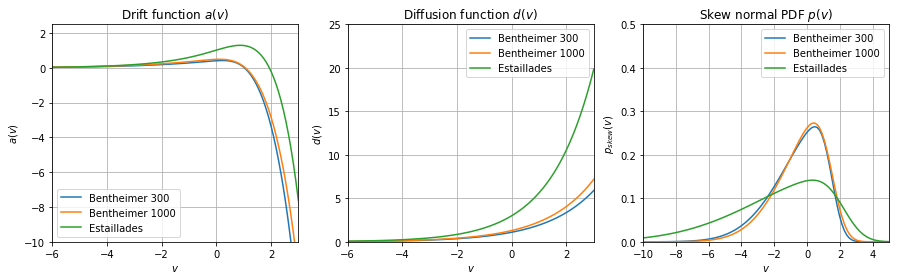

In [4]:
samples = [Bentheimer300, Bentheimer1000, Estaillades]
nv=100
(v_min, v_max) = (-6.0, 3.0)
v=np.linspace(v_min,v_max,nv)
dv= (v_max-v_min)/nv
fig, axs = plt.subplots(1,3, figsize= (15,4))

for (i,sample) in zip(range(len(samples)),samples) :
    axs[0].plot(v,a(v,sample),label = sample['name'])
    axs[1].plot(v,d(v,sample),label = sample['name'])
    axs[2].plot(np.linspace(-10,5,nv),p_skew(np.linspace(-10,5,nv),sample),label = sample['name'])

axs[0].set_title(r'Drift function $a(v)$')
axs[0].set_xlabel(r'$v$')
axs[0].set_ylabel(r'$a(v)$')
axs[0].set_xlim((-6,3))
axs[0].set_ylim((-10,2.5))
axs[0].legend()
axs[0].grid(True)

axs[1].set_title(r'Diffusion function $d(v)$')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel(r'$d(v)$')
axs[1].set_xlim((-6,3))
axs[1].set_ylim((0,25))
axs[1].legend()
axs[1].grid(True)

axs[2].set_title(r'Skew normal PDF $p(v)$')
axs[2].set_xlabel('$v$')
axs[2].set_ylabel(r'$p_{skew}(v)$')
axs[2].set_xlim((-10,5))
axs[2].set_ylim((0,0.5))
axs[2].legend()
axs[2].grid(True)

#### Log velocity markov process

In [5]:
#Log velocity magnitude model from Meyer and Bijeljic 2016
def LVM_process(sample, v0, dt, Nt, csf):
    rdm.seed() #redefine the seed
    delta     = 1.0 #Wiener process 
    track     = range(int(Nt/csf)) #If we do not want to track the whole evolution
    v_track   = np.zeros(int(Nt/csf)) #Resulting time serie
    v_        = v0
    for i in range(Nt) :
        if (i in track):
            v_track[i] = v_
        dv = a(v_,sample)*dt + np.sqrt(d(v_,sample))*stats.norm.rvs(scale=delta**2*dt)
        v_ = v_ + dv
    return v_track

## Running processes

#### Examples

In [6]:
samples = [Bentheimer300, Estaillades]
Nmp     = 5  #Number of Markov process
v0      = 1.0 #Initial velocity
dt      = 0.05 #Time step
Tmax    = 300.0 #Ending time
Nt      = int(Tmax/dt)+1 #Number of time steps
csf     = 5 #To eject highly correlated points
timerange = np.linspace(0,Nt*dt,int(Nt/csf))
MP_lvm  = {}

for sample in samples :
    MP_lvm[sample['name']]  = Parallel(n_jobs=8)(
        delayed(LVM_process)
        (sample, v0, dt, Nt, csf) for i in range(Nmp))

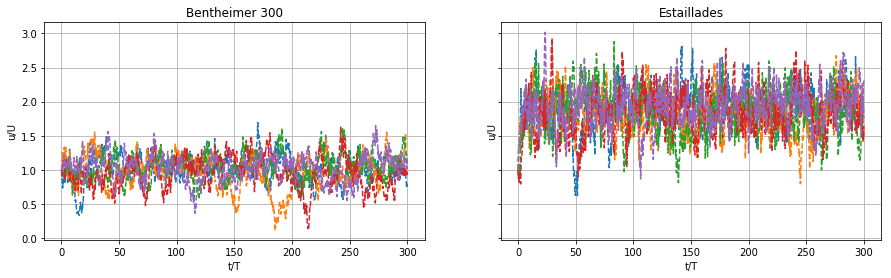

In [7]:
fig, axs = plt.subplots(1,2, sharey = True, figsize=(15,4))
for (i,sample) in zip(range(len(samples)),samples) :
    for n in range(Nmp) :
        axs[i].plot(timerange, MP_lvm[sample['name']][n],'--')
        axs[i].grid(True);
        axs[i].set_ylabel('u/U');
        axs[i].set_xlabel('t/T');
        axs[i].set_title(sample['name']);

### Process Statistics and PDF comparison

In [8]:
samples = [Bentheimer300, Estaillades]
Nmp     = 100
v0      = 1.0
dt      = 0.05
Tmax    = 150.0
Nt      = int(Tmax/dt)+1
csf     = 5.0
MP_lvm  = {}
#for sample in samples :
#    MP_lvm[sample['name']]  = np.array([DWM_process(Bentheimer300, v0, dt, Nt, csf) for i in range(Nmp)])
#    print(np.shape(MP_lvm[sample['name']]))
for sample in samples :
    MP_lvm[sample['name']]  = np.array(Parallel(n_jobs=8)(
        delayed(LVM_process)
        (sample, v0, dt, Nt, csf) for i in range(Nmp)))
    MP_lvm[sample['name']]=MP_lvm[sample['name']].reshape(int(Nt/csf)*Nmp)

In [9]:
print(np.shape(MP_lvm[Bentheimer300['name']]))


(60000,)


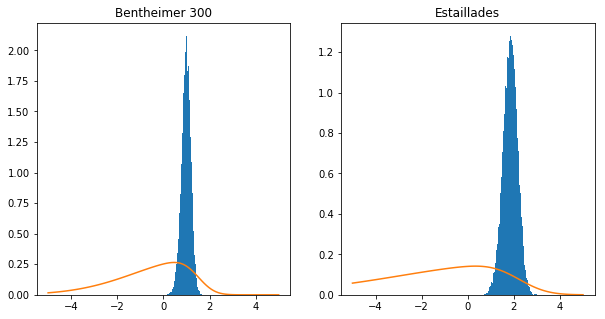

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
NBINS = 100
#for i in range(1,int(Nt/csf)) :
#    vpdf=plt.hist(MP_lvm[:,i], bins = 10, density = True, alpha = 0.3)
for (i,sample) in zip(range(len(samples)),samples) :
    axs[i].hist(MP_lvm[sample['name']], bins = NBINS, density = True, log = False)
    v = np.linspace(-5,5,100)
    axs[i].plot(v,p_skew(v,sample),label = str(sample));
    axs[i].set_title(sample['name'])

# Loading and processing DNS data

In [11]:
#diff = '0.0'; CSF = '1';
diff = '1.0'; CSF = '5';
filename = '../data/Bentheimer300/sl_out_M0_DM'+diff+'E-9_SLSM200_TMAX0.0E2_CSF'+CSF+'.dat'
#filename = '../data/Bentheimer300/streamlines.txt'
#dataDNS = np.loadtxt(filename,skiprows=1)

with open(filename, 'r') as f:
    lines = (line for line in f if len(line)>11)
    dataDNS = np.genfromtxt(lines)
dDNS = 3
tDNS=dataDNS[:,0]
NtDNS=len(tDNS)
print('NtDNS = '+str(NtDNS))
uxDNS = dataDNS[:,4]
uyDNS = dataDNS[:,5]
uzDNS = dataDNS[:,6]
del dataDNS

NtDNS = 584351


##### Computing Ux mean from Eulerian velocities and comparison with Lagrangian Ux mean

In [12]:
N    = 300
ux   = np.zeros((N,N,N))
ux   = np.loadtxt('../data/Bentheimer300/Ux.dat')
Umean = ux.mean() #Mean flow velocity
del ux
print('Ue_x mean = '+str(Umean)+', Up_xmean = '+str(uxDNS.mean()))

Ue_x mean = 3.918195014621102e-06, Up_xmean = 2.04617333710426e-05


In [13]:
#DNS log velocity magnitude
vDNS = [np.log(np.sqrt(ux**2+uy**2+uz**2)/Umean) for (ux,uy,uz) in zip(uxDNS, uyDNS, uzDNS) if np.sqrt(ux**2+uy**2+uz**2) > 0]
del uxDNS, uyDNS, uzDNS

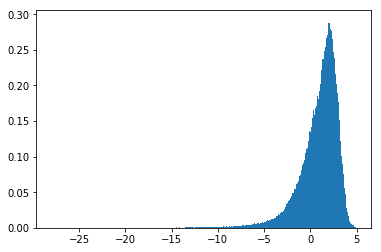

In [14]:
plt.hist(vDNS, bins = 1000, density = True);

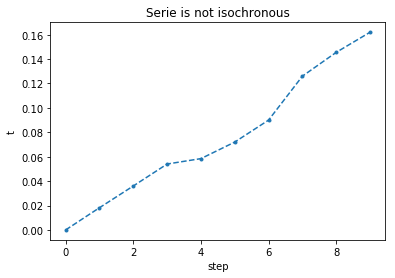

In [15]:
fig, ax = plt.subplots(1,1)
ax.plot(tDNS[range(10)],'.--');
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.set_title('Serie is not isochronous');

## Making DNS data isochronous

##### Compiling streamlines into one single stream lines (ssl)

Min. step time 	: 0.000241602262
Mean step time 	: 0.015172338232596193
ssl number of steps : 1996


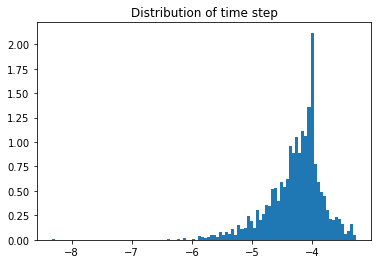

In [16]:
Npoints = 2000 #Selecting a bit less points for sake of ressource sparing
#Time step array :
dtDNS = [t1-t0 for (t1,t0) in zip(tDNS[range(1,Npoints)],tDNS[range(Npoints-1)])]
#Time step array for a single stream line
dtDNS_ssl = np.array([t1-t0 for (t1,t0) in zip(tDNS[range(1,Npoints)],tDNS[range(Npoints-1)]) if t1 > t0])
#single s.l. DNS data
tDNS_ssl = np.zeros(len(dtDNS_ssl))
T = 0
for i in range(len(dtDNS_ssl)) :
    tDNS_ssl[i] = T
    T += dtDNS_ssl[i]
vDNS_ssl = np.array([v for (v,dt) in zip(vDNS,dtDNS) if dt > 0])
# Minimal time step :
dt_min = min(dtDNS_ssl)
dt_mean = np.mean(dtDNS_ssl)
print ("Min. step time \t: "+str(dt_min))
print ("Mean step time \t: "+str(dt_mean))
print('ssl number of steps : '+str(np.shape(tDNS_ssl)[0]))

plt.title('Distribution of time step')
plt.hist(np.log(dtDNS_ssl),bins=100,density=True);

#### Isochronous transform of DNS data

In [17]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v

#isochronous transform for one point i
def isochronous_transform_process(t_serie, v_serie, dt, i) :
    t_i  = i*dt
    m  = 0
    t1 = -1
    while(t1 <= t_i) :
        m += 1;
        t1 = t_serie[m]
    v1 = v_serie[m]
    t0 = t_serie[m-1]
    v0 = v_serie[m-1]
    v_i  = lin_interp(v1,t1,v0,t0,t_i)
    return v_i

#parallel isochronous transform
def parallel_isochronous_transform(ncores, t_serie, v_serie, dt) :
    T_end    = t_serie[-1]
    Nt_iso   = int(T_end/dt)-1
    v_iso    = Parallel(n_jobs=ncores)(
        delayed(isochronous_transform_process)
        (t_serie, v_serie, dt, i) for i in range(Nt_iso))
    return v_iso

In [18]:
#Dictionnary to store isochronous transforms with various dt
dt1 = int(1000*dt_mean)/1000.0
dt2 = int(1000*dt_mean)/10000.0
dts = [dt1, dt2] #dt values for comparison
v_iso = {} #log velocity magn
t_iso = {} #time (linspace(0,T,dt))
Nt_iso = {}#number of points

#Isochronous transform
ncores = 6
for dt in dts :
    key = str(dt)
    start = time.time()
    v_iso[key]  = parallel_isochronous_transform(ncores, tDNS_ssl, vDNS_ssl, dt)
    Nt_iso[key] = len(v_iso[key])
    t_iso[key]  = np.linspace(0,dt*Nt_iso[key],Nt_iso[key])
    end = time.time()
    print('for dt  = '+key)
    print('\tNumber of points \t: '+str(Nt_iso[key]))
    print('\tTime needed \t: '+str(end-start))

for dt  = 0.015
	Number of points 	: 2017
	Time needed 	: 0.5699734687805176
for dt  = 0.0015
	Number of points 	: 20181
	Time needed 	: 2.214545488357544


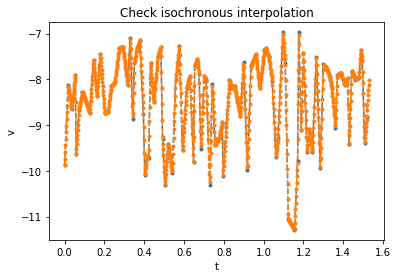

In [19]:
#Verification of the isochronous transform by comparing it to original data
N      = 100
dt_iso = dts[1]
Tmax   = tDNS_ssl[N]
N_iso  = int(Tmax/dt_iso)
key    = str(dt_iso)

fig, ax = plt.subplots(1,1)
ax.set_title('Check isochronous interpolation');
ax.plot(tDNS_ssl[0:N],vDNS_ssl[0:N],'.--'); #Isochronous series
ax.plot(t_iso[key][0:N_iso],v_iso[key][0:N_iso],'.--'); #rough DNS series
ax.set_xlabel('t');
ax.set_ylabel('v');

#### Comparisons to summarize

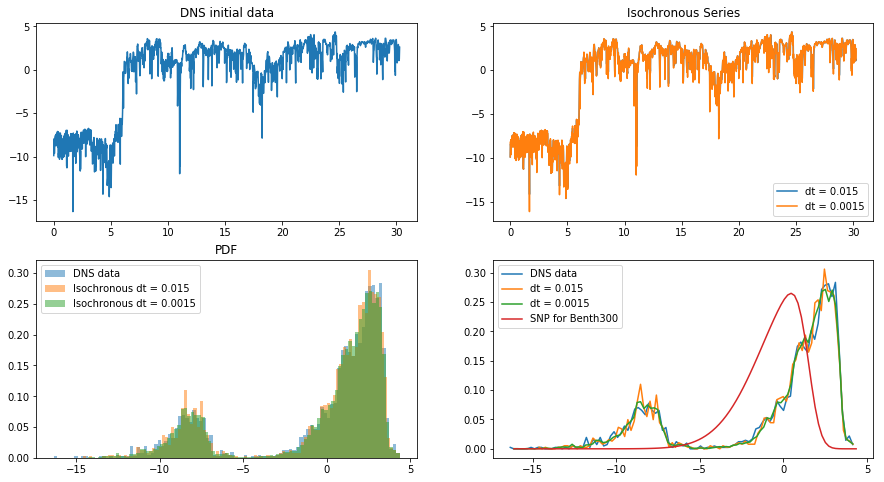

In [20]:
fig, axs = plt.subplots(2,2, figsize=(15,8));
axs[0,0].set_title('DNS initial data');
axs[0,0].plot(tDNS_ssl, vDNS_ssl);

axs[0,1].set_title('Isochronous Series');
for key in v_iso :
    axs[0,1].plot(t_iso[key], v_iso[key], label='dt = '+key);
    axs[0,1].legend();

hist_iso = {}
axs[1,0].set_title('Histogram coparison');
hist_DNS = axs[1,0].hist(vDNS_ssl, bins = 100, label = 'DNS data', density = True, alpha= 0.5);
for key in v_iso :
    hist_iso[key] = axs[1,0].hist(v_iso[key], bins = 100, label = 'Isochronous dt = '+key,  density = True, alpha= 0.5);
axs[1,0].legend();

axs[1,0].set_title('PDF');
axs[1,1].plot(hist_DNS[1][0:-1]    ,hist_DNS[0], label = 'DNS data')
for key in v_iso :
    axs[1,1].plot(hist_iso[key][1][0:-1]    ,hist_iso[key][0], label = 'dt = '+key)
axs[1,1].plot(hist_iso[key][1], p_skew(hist_iso[key][1],Bentheimer300), label = 'SNP for Benth300');
axs[1,1].legend();

## Comparing DNS data with Markov model and PDF

TypeError: '<' not supported between instances of 'dict' and 'float'

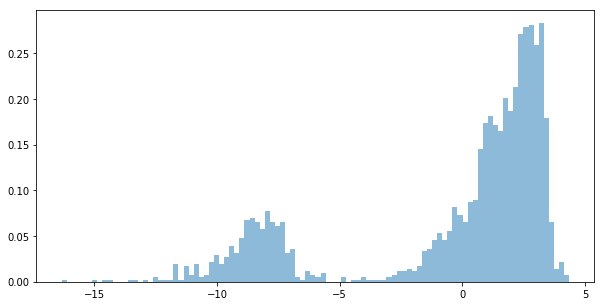

In [21]:
model ={
'name'  : 'Model',
'alpha' : -4.,
'mu'    :  0.85,
'sigma' :  1.5
}
fig, ax = plt.subplots(1,1,figsize=(10,5))
sample = Bentheimer300
data1 = vDNS_ssl
data2 = v_iso
data3 = MP_lvm[sample['name']]

ax.hist(data1, bins = 100, label = 'DNS data',       density = True, alpha= 0.5)
ax.hist(data2, bins = 100, label = 'Iso data',       density = True, alpha= 0.5)
ax.hist(data3, bins = 100, label = 'Markov process', density = True, alpha= 0.5)
v = np.linspace(-10,5,100)
ax.plot(v, p_skew(v,sample), label = 'SNP for Benth300');
ax.plot(v, p_skew(v,model),  label = 'DNS fitted SNP');
ax.grid(True)
ax.set_title(sample['name'])
ax.legend()
del data1, data2, data3